In [1]:
import torch
from torch import nn
import pandas as pd
import os
import pdb
from helpers.dataset import SequenceData
from helpers.seed import seed_dataloader, set_device, set_seed, get_generator
from torch.utils.data import DataLoader
from typing import *
import matplotlib.pyplot as plt

In [2]:
set_seed(10)
device = set_device()
print(device)

g_seed = get_generator(10)

Seed 10 has been set
cpu


In [3]:
class GeneralNN(nn.Module):
    """
    General, modular MLP

    has how ever many layers given by the len of hidden_dim
    adds dropout after every hidden layer
    adds relu after every hidden layer
    """
    def __init__(self, input_len: int, output_len: int, hidden_dim: List[int], dropout: float, bias = True):
        super().__init__()

        self.input_len = input_len
        self.output_len = output_len
        if hidden_dim: # check if there's anything in hidden_dim
            layers = [nn.Linear(input_len, hidden_dim[0], bias = bias)]

            for i, hidden in enumerate(hidden_dim[:-1]):
                layer = [nn.Linear(hidden, hidden_dim[i+1], bias = bias), nn.ReLU()]
                if dropout:
                    layer.append(nn.Dropout(dropout))
                layers += layer

            layers += [nn.Linear(hidden_dim[-1], output_len, bias = bias)]
        else:
            layers = [nn.Linear(input_len, output_len, bias = bias)]
        


        self.main = nn.Sequential(*layers)

    def forward(self, X):
        output = self.main(X)
        return output


def train(training_data, model, optimizer, loss):
    model.train()
    total = 0
    actuals = []
    preds = []

    for i, batch in enumerate(training_data):
        X, y = batch
        X = X.to(device)
        y = y.to(device)
        # flatten the X, since its sequence of the inputs
        X = torch.flatten(X)
        output = model(X)
        ls = loss(output,y)
        optimizer.zero_grad()
        ls.backward()
        optimizer.step()
        total += ls.item()

        actuals.append(y)
        preds.append(output)

    avg = total/len(training_data)
    print(f"Average Training loss is {avg}")

    return actuals, preds, avg

def test(testing_data, model, loss):
    model.eval()
    total = 0
    actuals = []
    preds = []

    with torch.no_grad():
        for i, batch in enumerate(testing_data):
            X,y = batch
            X = X.to(device)
            y = y.to(device)
            X = torch.flatten(X)
            output = model(X)
            ls = loss(output,y)
            total += ls.item()
            actuals.append(y.cpu().detach().numpy())
            preds.append(output.cpu().detach().numpy())

    avg = total/len(testing_data)
    print(f"Average Testing loss is {avg}")
        
    return actuals, preds, avg

In [4]:
training_data = SequenceData("y", ["x", "lagged_y"], 62, "data/train_less_perturbed_sin.csv")
testing_data = SequenceData("y", ["x", "lagged_y"], 62, "data/test_less_perturbed_sin.csv")
training_data = DataLoader(training_data, shuffle = False, worker_init_fn = seed_dataloader, generator = g_seed)
testing_data = DataLoader(testing_data, shuffle = False, worker_init_fn = seed_dataloader, generator = g_seed)

In [5]:
i, first = next(enumerate(training_data))
X, y = first
lr = 10**(-4)
input_len = len(torch.flatten(X))
output_len = 1
hidden_dim = [32, 32, 32]
bias = True
dropout = 0.2
epochs = 50
early_stop_val = 1

model = GeneralNN(input_len, output_len, hidden_dim, dropout, bias).to(device)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = lr)

val_info = {}
val_loss = []
train_loss = []
prev_mean_loss = 100
early_stop = 0
for i in range(epochs):
    train_actuals, train_preds, train_avg_loss = train(training_data, model, optimizer, loss)
    test_actuals, test_preds, test_avg_loss = test(testing_data, model, loss)
    val_info[i] = (test_actuals, test_preds)
    val_loss.append(test_avg_loss)
    train_loss.append(train_avg_loss)

    if test_avg_loss > prev_mean_loss:
        early_stop += 1
    else:
        early_stop = 0

    prev_mean_loss = test_avg_loss
    num_epochs = i
    if early_stop >= early_stop_val:
        print(f"Testing error increased, stopping at epoch {i}")
        break

torch.save(model, f"generalnn_trained_epoch{i}_{loss}_lr_{lr}")

Average Training loss is 0.9358348539874738
Average Testing loss is 0.6957745617603688
Average Training loss is 0.7936796316735907
Average Testing loss is 0.7034868577661293
Testing error increased, stopping at epoch 1


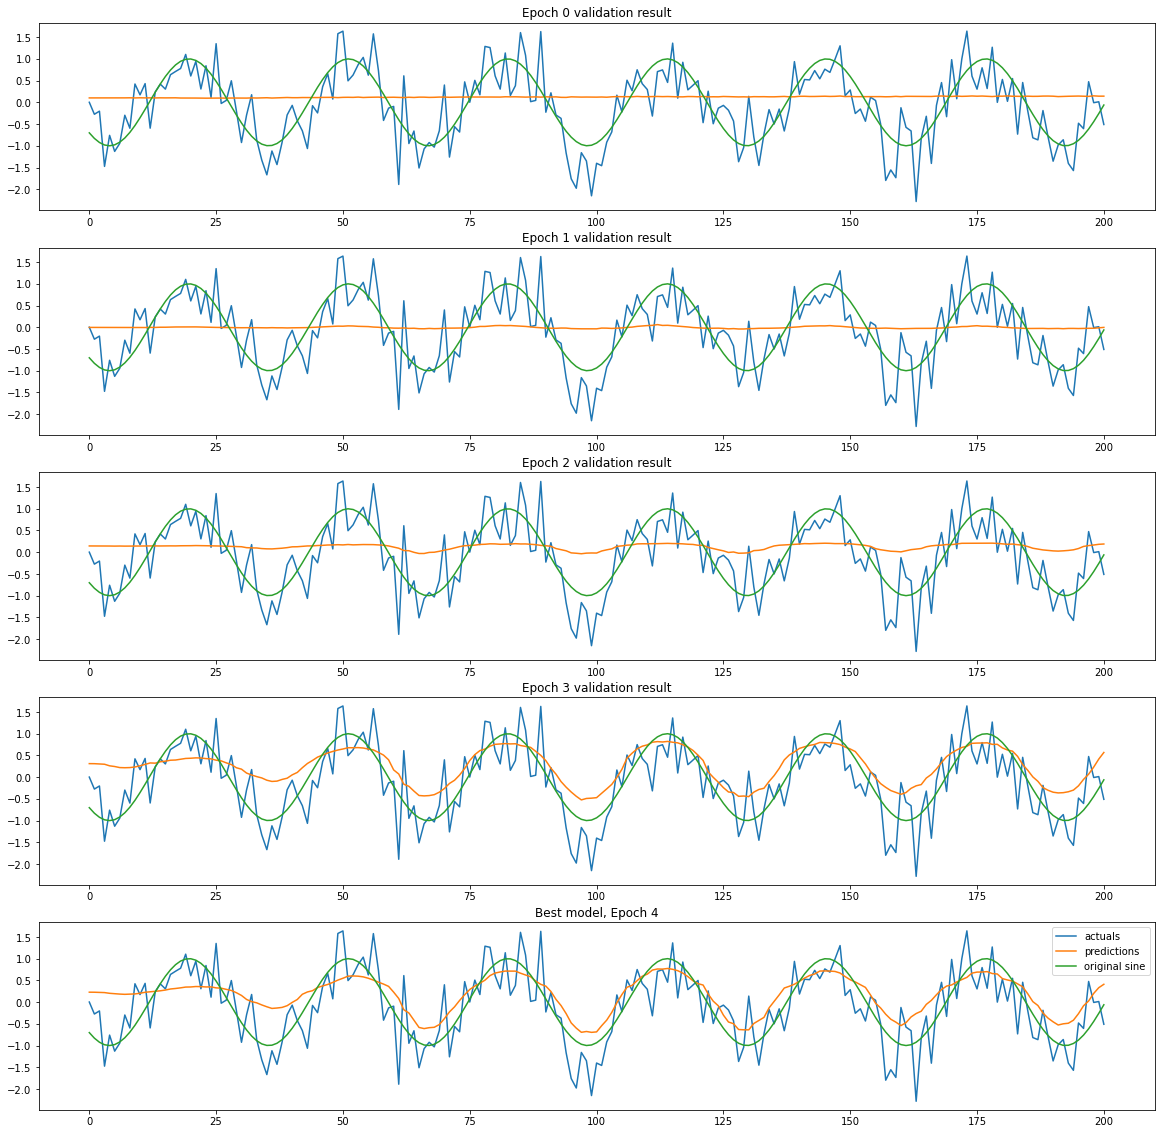

In [93]:
fig, ax = plt.subplots(5,1, figsize = (20,20))
minimum = min(val_loss)
minind = [i for i, val in enumerate(val_loss) if val == minimum]

df = pd.read_csv("data/test_less_perturbed_sin.csv")
x = df["x"].to_numpy()
x = torch.Tensor(x)
y = torch.sin(2*x)

for i in range(4):
    ax[i].plot(val_info[i][0], label = "actuals")
    ax[i].plot(val_info[i][1], label = "predicted")
    ax[i].plot(y, label = "original sine")
    ax[i].set_title(f"Epoch {i} validation result")

ax[4].plot(val_info[minind[0]][0], label = "actuals")
ax[4].plot(val_info[minind[0]][1], label = "predictions")
ax[4].plot(y, label = "original sine")
ax[4].set_title(f"Best model, Epoch {minind[0]}")
plt.legend()
fig.get_constrained_layout()
plt.savefig("preds_vs_vals.png", bbox_inches = "tight")

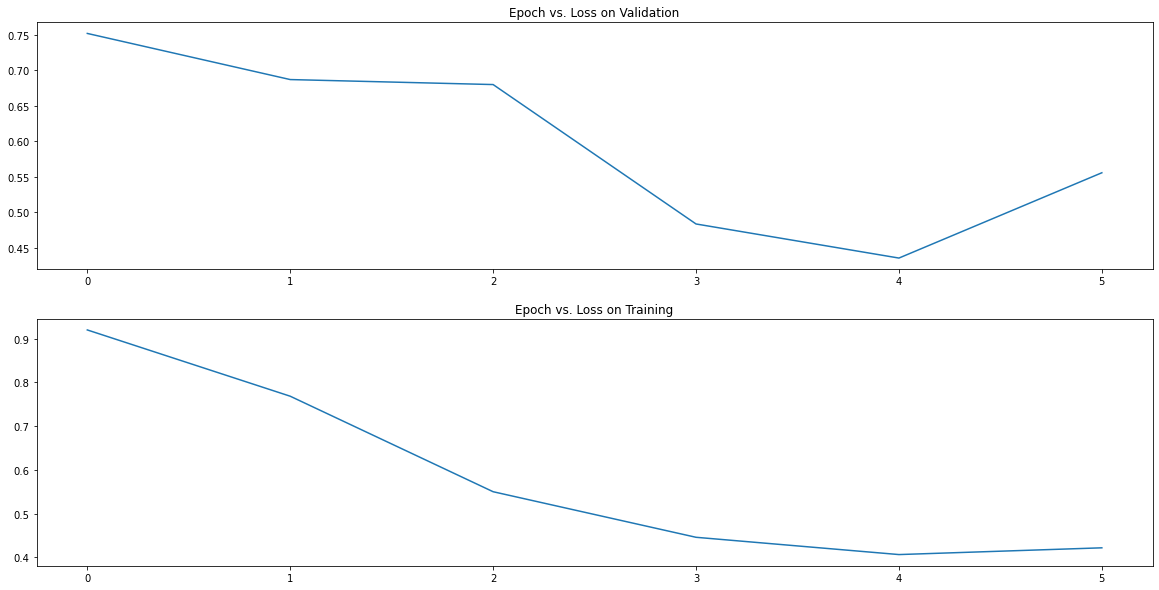

In [91]:
xval = range(len(val_loss))
xtrain = range(len(train_loss))
fig, ax = plt.subplots(nrows = 2, figsize = (20,10))
ax[0].plot(xval, val_loss, label = "Val Loss")
ax[0].set_title("Epoch vs. Loss on Validation")
ax[1].plot(xtrain, train_loss, label = "Train Loss" )
ax[1].set_title("Epoch vs. Loss on Training")
fig.get_constrained_layout()
plt.savefig("epoch_vs_loss.png", bbox_inches = "tight")